In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import hstack
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from transformers import BertForSequenceClassification, AutoModelForSequenceClassification
from transformers import AutoTokenizer, DataCollatorWithPadding
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.metrics import accuracy_score, f1_score, classification_report
import torch
from tqdm import tqdm
import os


os.environ["WANDB_DISABLED"] = "true"

In [31]:
print(f"GPU available: {torch.cuda.is_available()}")

GPU available: True


In [3]:
train_ds = load_dataset("pietrolesci/nli_fever", split="train")
val_ds   = load_dataset("pietrolesci/nli_fever", split="dev")

README.md: 0.00B [00:00, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


dataset_infos.json: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/46.5M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/4.95M [00:00<?, ?B/s]

data/dev-00000-of-00001.parquet:   0%|          | 0.00/4.44M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/208346 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/19998 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/19998 [00:00<?, ? examples/s]

Repo card metadata block was not found. Setting CardData to empty.


# EDA

In [4]:
train_ds

Dataset({
    features: ['cid', 'fid', 'premise', 'hypothesis', 'verifiable', 'fever_gold_label', 'label'],
    num_rows: 208346
})

For the NLI task we only need three columns: `premise`, `hypothesis` and `label`  
(`0` for entailment, `1` for neutral, `2` for contradiction).  
All remaining columns will be dropped.

In [5]:
for pre, hyp in zip(train_ds["premise"][:5], train_ds["hypothesis"]):
    print(pre)
    print(hyp)
    print()

Nikolaj Coster-Waldau worked with the Fox Broadcasting Company.
The Fox Broadcasting Company ( often shortened to Fox and stylized as FOX ) is an American English language commercial broadcast television network that is owned by the Fox Entertainment Group subsidiary of 21st Century Fox . Nikolaj Coster-Waldau . He then played Detective John Amsterdam in the short-lived Fox television series New Amsterdam ( 2008 ) , as well as appearing as Frank Pike in the 2009 Fox television film Virtuality , originally intended as a pilot . He became widely known to a broad audience for his current role as Ser Jaime Lannister , in the HBO series Game of Thrones .

Roman Atwood is a content creator.
Roman Atwood . He is best known for his vlogs , where he posts updates about his life on a daily basis . His vlogging channel , `` RomanAtwoodVlogs '' , has a total of 3.3 billion views and 11.9 million subscribers . He also has another YouTube channel called `` RomanAtwood '' , where he posts pranks .

R

In [6]:
train_ds = train_ds.rename_column("premise", "claim")
train_ds = train_ds.rename_column("hypothesis", "evidence")

val_ds = val_ds.rename_column("premise", "claim")
val_ds = val_ds.rename_column("hypothesis", "evidence")

In standard NLI datasets, the two text fields follow this convention:

* `premise`: the context or evidence
* `hypothesis`: the claim we want to evaluate

In this dataset, however, the semantics are inverted:
* the column called `premise` actually contains the claim, and the column
* called `hypothesis` contains the evidence.

To avoid confusion and make the rest of the code easier to read, I rename
the columns as follows:

- `premise` to `claim`
- `hypothesis` to `evidence`

In [7]:
print(f"Number of rows with empty evidence (train): {len(train_ds.filter(lambda x : x['evidence'] == ''))}")
print(f"Number of rows with empty evidence (validation): {len(val_ds.filter(lambda x : x['evidence'] == ''))}")

print(f"Number of rows with empty claim (train): {len(train_ds.filter(lambda x : x['claim'] == ''))}")
print(f"Number of rows with empty claim (validation): {len(val_ds.filter(lambda x : x['claim'] == ''))}")

Filter:   0%|          | 0/208346 [00:00<?, ? examples/s]

Number of rows with empty evidence (train): 5194


Filter:   0%|          | 0/19998 [00:00<?, ? examples/s]

Number of rows with empty evidence (validation): 1789


Filter:   0%|          | 0/208346 [00:00<?, ? examples/s]

Number of rows with empty claim (train): 0


Filter:   0%|          | 0/19998 [00:00<?, ? examples/s]

Number of rows with empty claim (validation): 0


In the train and validation datasets, some rows have an **empty** `evidence` field.  
In those cases, the model would be asked to decide whether a `claim` is supported or refuted by an `evidence` that does not actually exist.

This also makes it easy for the model to learn shortcuts such as:
“if `evidence` is empty, always predict class x”.
Such behaviour is harmful for our NLI setting, where the goal is to model the relationship between two texts.

For this reason, we **drop** all rows where the `evidence` column is empty.  
There are no empty values in the `claim` column.

In [8]:
train_ds = train_ds.filter(lambda x : x['evidence'] != '')
val_ds = val_ds.filter(lambda x : x['evidence'] != '')

Filter:   0%|          | 0/208346 [00:00<?, ? examples/s]

Filter:   0%|          | 0/19998 [00:00<?, ? examples/s]

In [9]:
pd.set_option("max.colwidth", None)

df_train = train_ds.to_pandas()
df_val = val_ds.to_pandas()

In [10]:
df_train.info()
df_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203152 entries, 0 to 203151
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   cid               203152 non-null  int64 
 1   fid               203152 non-null  object
 2   claim             203152 non-null  object
 3   evidence          203152 non-null  object
 4   verifiable        203152 non-null  int64 
 5   fever_gold_label  203152 non-null  object
 6   label             203152 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 10.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18209 entries, 0 to 18208
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cid               18209 non-null  int64  
 1   fid               18209 non-null  object 
 2   claim             18209 non-null  object 
 3   evidence          18209 non-null  object 
 4   verifiable        0 n

Train labels distribution: label
0    0.608382
2    0.241755
1    0.149863
Name: proportion, dtype: float64




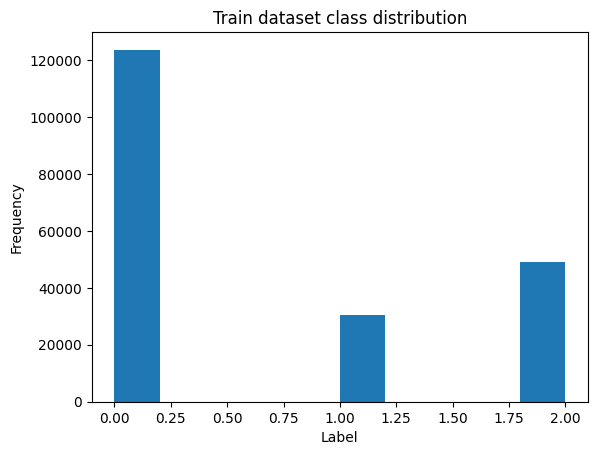

In [11]:
print(f"Train labels distribution: {df_train['label'].value_counts(normalize = True)}\n\n")

plt.hist(df_train["label"])
plt.title("Train dataset class distribution")
plt.xlabel("Label")
plt.ylabel("Frequency")
plt.show()

The labels are heavily **skewed** towards class `0` (entailment), with over 60% of the training data. The least frequent class is `1` (neutral).

# Logistic regression

To establish a low baseline for performance on this task, I'll use **TF-IDF** with **logistic regression**, and evaluate it on the the validation dataset. The expected accuracy is low, since it's a very basic technique and doesn't really allow for a model which "understands" meaning.

In [12]:
import string
from nltk.corpus import stopwords
stopwords_set = stopwords.words("english")

def process_text(text):
    nopunc = text.translate(str.maketrans("", "", string.punctuation))
    no_stopwords = " ".join([word.lower() for word in nopunc.split() if word.lower() not in stopwords_set])
    
    return no_stopwords

df_train_processed = df_train.copy()
df_val_processed = df_val.copy()
dataframes = [df_train_processed, df_val_processed]

cols = ["claim", "evidence"]
for df in dataframes:
    for col in cols:
        df[col] = df[col].apply(process_text)

We first make a copy of the dataframes so we can preserve the original, unprocessed text for explainability.  
The TF–IDF pipeline transforms the text into a sparse vector representation, which is not interpretable for humans.  
We start by removing **punctuation** and **stopwords** for the `claim` and `evidence` columns.

In [13]:
for df in dataframes:
    print(f"{df['claim'].head().values}\n")

['nikolaj costerwaldau worked fox broadcasting company'
 'roman atwood content creator' 'roman atwood content creator'
 'history art includes architecture dance sculpture music painting poetry literature theatre narrative film photography graphic arts'
 'adrienne bailon accountant']

['colin kaepernick became starting quarterback 49ers 63rd season national football league'
 'tilda swinton vegan' 'fox 2000 pictures released film soul food'
 'anne rice born new jersey'
 'telemundo englishlanguage television network']



In [14]:
#devo fare tf idf vectorizer per hypothesis e per premise, e poi concatenare le feature
from sklearn.feature_extraction.text import TfidfVectorizer

hyp_vect = TfidfVectorizer(max_features = 50000, min_df = 1, ngram_range = (1, 2))
pre_vect = TfidfVectorizer(max_features = 50000, min_df = 1, ngram_range = (1, 2))

X_train_hyp_vect = hyp_vect.fit_transform(df_train_processed["evidence"])
X_train_pre_vect = pre_vect.fit_transform(df_train_processed["claim"])

X_val_hyp_vect = hyp_vect.transform(df_val_processed["evidence"])
X_val_pre_vect = pre_vect.transform(df_val_processed["claim"])

We set `ngram_range` to `(1, 2)` so that the vectorizer includes both single words and word pairs, allowing it to capture a bit more meaning.  
The `max_features` parameter is set to `50000`, which is a reasonable value for the size of this dataset.

In [16]:
X_train = hstack([X_train_hyp_vect, X_train_pre_vect])
X_val = hstack([X_val_hyp_vect, X_val_pre_vect])

y_train = df_train["label"]
y_val = df_val["label"]

We concatenate the sparse matrices generated for the `claim` and `evidence` features using the vectorizer into a single matrix. This combined matrix is then used as input for the model.

In [17]:
clf = LogisticRegression(max_iter = 1000, n_jobs = -1, solver = "saga", class_weight = "balanced")
clf.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, n_jobs=-1,
                   solver='saga')

Accuracy: 0.49189961008292604
F1-score macro average: 0.48756983211497973


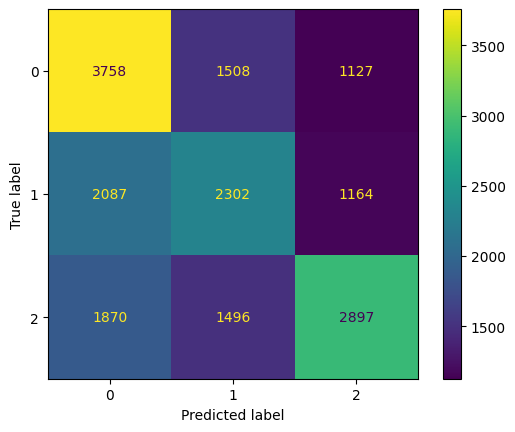

In [18]:
y_pred = clf.predict(X_val)
print(f"Accuracy: {accuracy_score(y_val, y_pred)}")
print(f"F1-score macro average: {f1_score(y_val, y_pred, average = 'macro')}")
ConfusionMatrixDisplay.from_predictions(y_val, y_pred)
plt.show()

## Results

- **Accuracy**: 0.492
- **F1 Macro**: 0.488

The accuracy of `0.492` and F1 macro score of `0.488` are reasonable given that TF-IDF only captures surface-level features and not semantic meaning. For context, a model making random predictions would achieve approximately `33%` accuracy. Our logistic regression model shows a `+16%` improvement, though it is still far from optimal.


# Transformer

In this section we use a Transformer-based architecture.  
Transformers can achieve a high performance on NLP tasks by **fine-tuning** a pre-trained model on our specific dataset.

Large language models (LLMs) could also be used in a zero-shot setting, without any task-specific training, but they are typically far more computationally expensive.  
Fine-tuning a smaller Transformer is a more efficient and practical choice for this project.


In [20]:
print(f"Average claim length (characters): {df_train['claim'].str.len().mean()}")
print(f"Average evidence length (characters): {df_train['evidence'].str.len().mean()}")

Average claim length (characters): 44.03981255414665
Average evidence length (characters): 329.5856550760022


We inspect the average character length of `claim` and `evidence` to choose a suitable `max_length` for tokenization.

In [21]:
cols_to_remove = ["cid", "fid", "verifiable", "fever_gold_label"]
train_ds = train_ds.remove_columns(cols_to_remove)
val_ds = val_ds.remove_columns(cols_to_remove)

We remove columns not needed for the task.

In [22]:
model_name = "microsoft/deberta-v3-base"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast = True)

def tokenize(batch):
    return tokenizer(
        batch["claim"],
        batch["evidence"],
        truncation = True,
        padding = "max_length",
        max_length = 256
    )

train_ds = train_ds.map(tokenize, batched = True)
val_ds = val_ds.map(tokenize, batched = True)

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Map:   0%|          | 0/203152 [00:00<?, ? examples/s]

Map:   0%|          | 0/18209 [00:00<?, ? examples/s]

We chose DeBERTa (improved version of BERT) for this problem, because of its more efficient training and great results on benchmarks. We started by tokenizing the `claim` and `evidence` columns.

In [23]:
train_ds = train_ds.remove_columns(["claim", "evidence"])
val_ds = val_ds.remove_columns(["claim", "evidence"])

train_ds.set_format("torch")
val_ds.set_format("torch")

We remove the non-tokenized columns and transform the datasets into **PyTorch** format for compatibility.

In [24]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis = -1)
    return {
        "accuracy" : accuracy_score(labels, preds),
        "f1_macro" : f1_score(labels, preds, average = "macro")
    }

We define a **metric function** to evaluate the model during training, so that we can use the `EarlyStoppingCallback`.  
The function computes accuracy and macro F1.

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch", #forse diventa evaluation
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    load_best_model_at_end=True,
    logging_steps = 100,
    save_total_limit = 2,
    metric_for_best_model = "f1_macro",
    greater_is_better = True
    #dataloader_num_workers=4,
)

early_stopping = EarlyStoppingCallback(
    early_stopping_patience = 2
)

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels = 3)
trainer = Trainer(model = model,
                 train_dataset = train_ds,
                 eval_dataset = val_ds,
                 args = training_args,
                 tokenizer = tokenizer,
                 compute_metrics = compute_metrics,
                 callbacks = [early_stopping])

We create a `Trainer` object, which handles the entire training loop for us.  
We pass a `TrainingArguments` instance to specify the training configuration, including the number of epochs.

We set `num_train_epochs` to `10`, which is deliberately high for a fine-tuning setup.  
However, thanks to the `EarlyStoppingCallback`, training will stop automatically once the validation macro F1 stops improving.


In [ ]:
trainer.train()

Training logs reconstructed (not the live output because of a saving problem):

| Epoch | Training Loss | Validation Loss | Accuracy | F1 Macro |
|-------|---------------|----------------|----------|----------|
| 1     | 0.328800      | 0.832522       | 0.752375 | 0.731956 |
| 2     | 0.302900      | 0.799927       | 0.765391 | 0.752787 |
| 3     | 0.240600      | 0.853726       | 0.764237 | 0.753588 |
| 4     | 0.180800      | 0.968894       | 0.755615 | 0.746164 |
| 5     | 0.177900      | 1.036060       | 0.758636 | 0.749787 |

The best model is obtained at epoch 3, with F1 Macro at **0.754**.

In [25]:
huggingface_path = "fabiocigaina/deberta-v3-base-nli-fever-pietrolesci"
model_trained = AutoModelForSequenceClassification.from_pretrained(huggingface_path)

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/738M [00:00<?, ?B/s]

We load the fine-tuned model from its public **Hugging Face repository**, which we uploaded after completing training.


In [26]:
model_trained.eval()
device = "cuda" if torch.cuda.is_available() else "cpu"
model_trained.to(device)

val_loader = torch.utils.data.DataLoader(val_ds, batch_size = 32)
all_preds = []
all_probs = []
all_labels = []

with torch.no_grad():        
    for batch in tqdm(val_loader, desc = "Inference on test set"):
        batch = {k : v.to(device) for k, v in batch.items()}
        labels = batch.pop("label")

        logits = model_trained(**batch).logits
        probs = torch.softmax(logits, dim = -1).cpu().numpy()
        preds = np.argmax(probs, axis = -1)

        all_preds.append(preds)
        all_probs.append(probs)
        all_labels.append(labels.cpu())

all_preds = np.concatenate(all_preds, axis = 0)
all_probs = np.concatenate(all_probs, axis = 0)
all_labels = torch.cat(all_labels).numpy()

Inference on test set: 100%|██████████| 570/570 [03:07<00:00,  3.04it/s]


We perform **inference** on the validation dataset after switching the model to `eval` mode, which disables dropout and removes training-time randomness, making the outputs effectively **deterministic** for evaluation.


Accuracy score: 0.7642374649898402
F1-score macro average: 0.7535875977246684
              precision    recall  f1-score   support

           0       0.78      0.90      0.84      6393
           1       0.71      0.58      0.64      5553
           2       0.78      0.79      0.79      6263

    accuracy                           0.76     18209
   macro avg       0.76      0.76      0.75     18209
weighted avg       0.76      0.76      0.76     18209



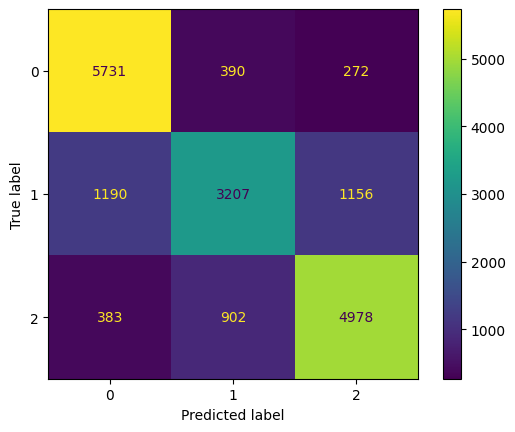

In [27]:
print(f"Accuracy score: {accuracy_score(all_labels, all_preds)}")
print(f"F1-score macro average: {f1_score(all_labels, all_preds, average = 'macro')}")

print(classification_report(all_labels, all_preds))
disp = ConfusionMatrixDisplay.from_predictions(all_labels, all_preds)
plt.show()

## Results

The overall accuracy is `0.764`, but a more informative metric in this setting is the macro F1 score, which is `0.754`.

Looking at F1 scores per class:

- **Class `0` (entailment)** has the highest F1, meaning the model handles entailment cases relatively well.
- **Class `1` (neutral)** has the lowest F1: the model struggles when the claim is neither clearly supported nor clearly contradicted by the evidence. This is expected, since there is less training data for this label, so the model has seen fewer neutral pairs.
- **Class `2` (contradiction)** achieves an F1 score between the other two classes, indicating solid but not perfect performance.

The confusion matrix shows that most errors involve the neutral class being confused with another label. The model seems to have difficulty drawing a sharp line between neutral vs. entailment and neutral vs. contradiction in borderline cases. The most common mistake is predicting `entailment` instead of `neutral`, followed by predicting `contradiction` for `neutral` examples.


In [20]:
for i in range(3):
    for j in range(3):
        if i == j:
            continue
        mask = (all_labels == i) & (all_preds == j)
        print(f"Predicted {j}, ground truth {i}:")
        example = df_val.loc[mask, ["claim", "evidence"]].sample(random_state = 40)
        print(f"{example['claim'].values[0]}\n{example['evidence'].values[0]}\n")

Predicted 1, ground truth 0
Richard Kuklinski led a double life.
Richard Kuklinski . His family was apparently unaware of Kuklinski 's double life and crimes .

Predicted 2, ground truth 0
Birmingham is a large town.
Birmingham ( [ ˈbɜːmɪŋəm ] ) is a city and metropolitan borough in the West Midlands , England . It is the largest and most populous British city outside London , with a population of 1,101,360 in 2014 . A medium-sized market town in the medieval period , Birmingham grew to international prominence in the 18th century at the heart of the Midlands Enlightenment and subsequent Industrial Revolution , which saw the town at the forefront of worldwide advances in science , technology , and economic development , producing a series of innovations that laid many of the foundations of modern industrial society .

Predicted 0, ground truth 1
Benjamin Franklin, Founding Father, lead the American Revolution.
The American Revolution was a political upheaval that took place between 176

### Error analysis (sample cases)

**Predicted `1`, ground truth `0` – Kuklinski’s “double life”**

Here the model predicts `neutral` instead of `entailment`:

The `evidence` explicitly mentions *“Kuklinski's double life”*, so the claim is clearly supported. The model seems overly conservative: even with almost exact lexical overlap, it does not predict entailment, possibly treating the rest of the sentence (family, crimes) as distracting context.


**Predicted `2`, ground truth `0` – Birmingham**

This is a typical failure case. The `evidence` is very long, and the model struggles to focus on the key idea that Birmingham is a large urban area. The mention of *“medium-sized market town in the medieval period”* can conflict, at a surface level, with *“large town”* in the claim. The model appears to overreact to this lexical mismatch and predicts `contradiction` instead of recognising that the text is compatible with the claim.


**Predicted `0`, ground truth `1` – Franklin and the American Revolution**

The `evidence` confirms that Franklin was a Founding Father and describes the American Revolution, but it never states that he *led* it. The correct label is `neutral`, yet the model predicts `entailment`. This suggests an overgeneralisation pattern: once it sees “Benjamin Franklin” and “American Revolution” together, it infers a stronger relationship than what is actually supported by the text.


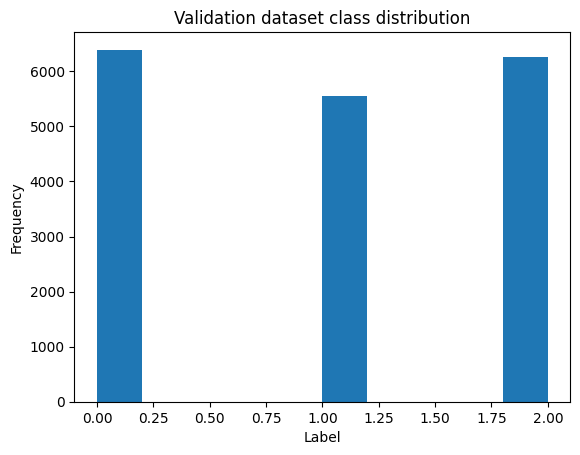

In [28]:
plt.hist(df_val["label"])
plt.title("Validation dataset class distribution")
plt.xlabel("Label")
plt.ylabel("Frequency")
plt.show()

There is a clear **difference** in label **distribution** between the train and validation sets.  
In the validation set, all three classes appear in roughly **equal** proportions, while the training data is heavily skewed.

It is therefore interesting to also evaluate the model on a validation subset whose class distribution matches the training set. Intuitively, this should **boost accuracy**, since the model has seen many more examples from the majority class during training.


In [29]:
train_distributions = df_train["label"].value_counts(normalize = True)
train_distributions = train_distributions / train_distributions[0];

rng = np.random.default_rng(42)
idx0 = np.where(all_labels == 0)[0]
idx1 = np.where(all_labels == 1)[0]
idx2 = np.where(all_labels == 2)[0]


n1_target = int(round(train_distributions[1] * len(idx0)))
n2_target = int(round(train_distributions[2] * len(idx0)))

idx1_sel = rng.choice(idx1, size=n1_target, replace=False)
idx2_sel = rng.choice(idx2, size=n2_target, replace=False)

# tutti gli indici che teniamo
idx_keep = np.concatenate([idx0, idx1_sel, idx2_sel])

# mask booleana sull'array completo
mask = np.zeros(len(all_labels), dtype=bool)
mask[idx_keep] = True

for i in range(3):
    print(f"Class {i}: {(all_labels[idx_keep] == i).sum()/len(idx_keep)}")

Class 0: 0.6083936048724781
Class 1: 0.149885801294252
Class 2: 0.24172059383326988


We printed the distribution of the new validation dataset, which now matches the train distribution.

In [30]:
print(f"Accuracy score: {accuracy_score(all_labels[idx_keep], all_preds[idx_keep])}")
print(f"F1-score macro average: {f1_score(all_labels[idx_keep], all_preds[idx_keep], average = 'macro')}")


Accuracy score: 0.8241339931480777
F1-score macro average: 0.750645380064119


There is a positive `+6%` change in accuracy when the model is evaluated on data with the same class distribution as the training set.  
This happens because the new validation split contains more examples from the class the model is **best** at (class `0`).

The macro F1 score, on the other hand, **stays roughly the same** apart from minor random fluctuations, since it gives the same importance to all classes.  
This is why macro F1 is a better choice of metric for this kind of task: it makes the evaluation more robust to class imbalance.


# Conclusion

In this notebook we tackled a Natural Language Inference (NLI) task and went through the full workflow from raw data to a fine-tuned Transformer model.

We:
- performed exploratory data analysis (EDA) and inspected the label distribution;
- identified and removed rows with missing `evidence`, which do not define a valid NLI input;
- established a classical ML baseline using TF–IDF features;
- fine-tuned and evaluated a `DeBERTa` model, achieving an accuracy of around `0.76` and a macro F1 score of about `0.75`.

We also showed how **class imbalance** affects evaluation: accuracy improves when the validation distribution matches the training set, while macro F1 remains more stable, confirming it as a better metric for this kind of task.

Possible future work includes adding **explainability**, by visualising the model’s `attention` patterns or using gradient-based methods to highlight which tokens contribute most to each prediction. Also, evaluating the model on additional datasets would be useful, to test generalisation.
